In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
sns.set_style("darkgrid")
sns.set_palette("dark")

import os

from pipeline.preprocessing import preprocess
from pipeline.walkforward import WFCVGenerator
from config.config_types import AppConfig
import torch

from utils.paths import CONFIG_DIR, SP500COPY_PATH, SP500_PATH, DATA_DIR, VOL_EXPERIMENTS_DIR, PRICE_EXPERIMENTS_DIR

DEVICE = "cuda" # change this to "cpu" if running w/o gpu

In [2]:

fold_num = 0
name  = "exp_036_lstm_100_muon_lr"
trial = "trial_search_best" 

# -------- load config --------
base = f"{VOL_EXPERIMENTS_DIR}/{name}/{trial}/"
conifg_path = f"{base}config_snapshot.json"

with open(conifg_path, 'r') as f:
    cfg = json.load(f)

cfg = cfg["cfg"]

cfg_lstm = AppConfig.from_dict(cfg)

cfg_lstm.trainer.hparams.get("optimizer_type")
cfg_lstm.trainer.hparams.get("weight_decay")

if cfg_lstm.data["df_master"] is not None:
    df_master_path =  cfg_lstm.data["df_master"]
    df_master = pd.read_parquet(f"{DATA_DIR}/{df_master_path}")
    #print(f"provided df master: {df_master_path}\n{df_master.head()}")
else:
    df_master = None



cfg_lstm.walkforward.lags = 100
cfg_lstm.walkforward.clip = 0.5
print(f"Clipping {cfg_lstm.walkforward.clip}% of the observations, used 0.1% for training")
wf = WFCVGenerator(cfg_lstm.walkforward, keep_id_col=True)
wf.df_master

NameError: name 'VOL_EXPERIMENTS_DIR' is not defined

In [11]:
df_master = wf.df_master.sort_values(["permno", "window"]).copy().reset_index(drop=True)
df_master

,permno,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,y,window
0,10078,0.384798,0.276643,1.156039,0.500828,0.279505,0.447830,0.681163,0.217379,0.164337,...,0.654951,0.222019,0.249885,0.497562,0.416215,2.106628,0.623645,2.084225,1.383864,"(0, 100)"
1,10078,0.276643,1.156039,0.500828,0.279505,0.447830,0.681163,0.217379,0.164337,0.154433,...,0.222019,0.249885,0.497562,0.416215,2.106628,0.623645,2.084225,1.383864,0.296920,"(1, 101)"
2,10078,1.156039,0.500828,0.279505,0.447830,0.681163,0.217379,0.164337,0.154433,0.231465,...,0.249885,0.497562,0.416215,2.106628,0.623645,2.084225,1.383864,0.296920,0.186674,"(2, 102)"
3,10078,0.500828,0.279505,0.447830,0.681163,0.217379,0.164337,0.154433,0.231465,0.132719,...,0.497562,0.416215,2.106628,0.623645,2.084225,1.383864,0.296920,0.186674,0.591926,"(3, 103)"
4,10078,0.279505,0.447830,0.681163,0.217379,0.164337,0.154433,0.231465,0.132719,0.143729,...,0.416215,2.106628,0.623645,2.084225,1.383864,0.296920,0.186674,0.591926,0.141732,"(4, 104)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3046922,93436,0.190030,1.130963,0.337202,0.261063,0.220466,0.085527,0.062634,0.193834,0.201343,...,0.119712,0.154518,0.226704,0.392204,1.953750,0.745704,0.573907,0.254501,0.141778,"(6184, 6284)"
3046923,93436,1.130963,0.337202,0.261063,0.220466,0.085527,0.062634,0.193834,0.201343,0.164100,...,0.154518,0.226704,0.392204,1.953750,0.745704,0.573907,0.254501,0.141778,0.066867,"(6185, 6285)"
3046924,93436,0.337202,0.261063,0.220466,0.085527,0.062634,0.193834,0.201343,0.164100,0.167549,...,0.226704,0.392204,1.953750,0.745704,0.573907,0.254501,0.141778,0.066867,0.202465,"(6186, 6286)"
3046925,93436,0.261063,0.220466,0.085527,0.062634,0.193834,0.201343,0.164100,0.167549,0.144297,...,0.392204,1.953750,0.745704,0.573907,0.254501,0.141778,0.066867,0.202465,0.087621,"(6187, 6287)"


In [5]:
f_columns = [col for col in wf.df_master if "feature" in col]
X = df_master.copy()[f_columns]
X = X.to_numpy()
y = df_master.copy()["y"]
y = y.to_numpy()

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso



data = {}



for i, fold_data in enumerate(wf.folds()):
    size = fold_data[4]

    data[i] = fold_data
    print(i)
    #if i == fold_num:
    #    break


Xtr, ytr, Xv, yv, Xte, yte, Xtr_val, ytr_val, Xte_merged, yte_merged, id_tr, id_v, id_te, windows_tr, windows_te, windows_v = data[0]



NameError: name 'wf' is not defined

In [ ]:
X = 
y = np.concatenate([ytr_val, yte_merged])


array([ 1.47783476, -0.06719031,  0.91811546, ..., -0.3413279 ,
       -0.0646364 ,  1.19948034], shape=(2379248,))

In [16]:
fold = 0
while True:    
    try:
        print("-"*50)
        print(f'fold: {fold}')
        for arr in data[fold]:
            print(f"{np.mean(arr):.4f}, {np.std(arr):.4f}, {[format(p, ".4f") for p in np.percentile(arr, q=[0.05, 0.25, 0.5, 0.75, 0.95])]},{np.min(arr):.4f}, {np.max(arr):.4f}")
        fold +=1
    except KeyError:
        break

--------------------------------------------------
fold: 0
0.0000, 1.0000, ['-2.7347', '-2.4958', '-2.3343', '-2.2262', '-2.1568'],-2.8647, 3.6893
0.0000, 1.0000, ['-2.7122', '-2.4859', '-2.3289', '-2.2217', '-2.1541'],-2.8145, 3.6626
-0.3361, 0.9182, ['-2.7668', '-2.5686', '-2.4236', '-2.3282', '-2.2684'],-2.8652, 3.6897
-0.3095, 0.9270, ['-2.7441', '-2.5599', '-2.4187', '-2.3239', '-2.2667'],-2.8149, 3.6616
-0.0340, 0.8939, ['-2.6102', '-2.2988', '-2.1417', '-2.0360', '-1.9712'],-2.8643, 3.6900
-0.0353, 0.8821, ['-2.5829', '-2.2774', '-2.1226', '-2.0140', '-1.9499'],-2.8141, 3.6619
0.0000, 1.0000, ['-2.6836', '-2.4545', '-2.2976', '-2.1927', '-2.1263'],-2.8054, 3.8005
-0.0000, 1.0000, ['-2.6668', '-2.4509', '-2.2969', '-2.1943', '-2.1292'],-2.7599, 3.7767
0.0534, 0.9025, ['-2.5476', '-2.2333', '-2.0747', '-1.9679', '-1.9024'],-2.8045, 3.8008
0.0451, 0.8901, ['-2.5258', '-2.2174', '-2.0613', '-1.9517', '-1.8870'],-2.7590, 3.7760
--------------------------------------------------
fold:

In [17]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# 1. Helper to flatten 3D/2D time-series data for OLS
def prepare_sklearn_input(X):
    X = np.asarray(X)
    if X.ndim == 3: # (N, T, D) -> (N, T*D)
        N, T, D = X.shape
        return X.reshape(N, -1)
    elif X.ndim == 2: # (N, T) -> (N, T)
        return X
    return X

# 2. Prepare the data
# Xtr_val is your training set, Xte is your test set
X_train_ols = prepare_sklearn_input(Xtr_val)
X_all_ols = prepare_sklearn_input(X)

# Ensure targets are the right shape (N,) or (N, 1)
y_train_ols = np.asarray(ytr_val)
#y_all_ols = np.asarray(y)

# 3. Fit OLS
ols_full = LinearRegression()
ols_full.fit(X_train_ols, y_train_ols)
a = 0.05
lasso_full = Lasso(fit_intercept=True, alpha=a).fit(X_train_ols, y_train_ols)


# 4. Predict
y_pred_all_ols = ols_full.predict(X_all_ols)
y_pred_tr_ols = ols_full.predict(X_train_ols)
y_pred_all_lasso = lasso_full.predict(X_all_ols)
y_pred_tr_lasso = lasso_full.predict(X_train_ols)

# 5. Check Metrics
# Flatten both for safe comparison
mse_ols = mean_squared_error(y.ravel(), y_pred_all_ols.ravel()) 
mse_lasso = mean_squared_error(y.ravel(), y_pred_all_lasso.ravel()) 
mse_tr_ols  = mean_squared_error(y_train_ols.ravel(), y_pred_tr_ols.ravel())
print(f"OLS All MSE: {mse_ols:.6f}")
print(f"LASSO All MSE: {mse_lasso:.6f}")
print(f"OLS Train MSE: {mse_tr_ols:.6f}")
print(f"LASSO Train MSE: {mse_tr_ols:.6f}")
print(np.var(ytr_val))

OLS All MSE: 179.736138
LASSO All MSE: 178.742075
OLS Train MSE: 0.529223
LASSO Train MSE: 0.529223
1.0000000000000002


In [14]:
a = 0.05
df_master[f"lasso_{a}"] = y_pred_all_lasso
df_master[f"ols"] = y_pred_all_ols

df_master

,permno,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,y,window,lasso_0.05,ols
0,10078,0.384798,0.276643,1.156039,0.500828,0.279505,0.447830,0.681163,0.217379,0.164337,...,0.249885,0.497562,0.416215,2.106628,0.623645,2.084225,1.383864,"(0, 100)",0.910211,0.992982
1,10078,0.276643,1.156039,0.500828,0.279505,0.447830,0.681163,0.217379,0.164337,0.154433,...,0.497562,0.416215,2.106628,0.623645,2.084225,1.383864,0.296920,"(1, 101)",0.878012,0.957567
2,10078,1.156039,0.500828,0.279505,0.447830,0.681163,0.217379,0.164337,0.154433,0.231465,...,0.416215,2.106628,0.623645,2.084225,1.383864,0.296920,0.186674,"(2, 102)",0.672790,0.751021
3,10078,0.500828,0.279505,0.447830,0.681163,0.217379,0.164337,0.154433,0.231465,0.132719,...,2.106628,0.623645,2.084225,1.383864,0.296920,0.186674,0.591926,"(3, 103)",0.515688,0.593544
4,10078,0.279505,0.447830,0.681163,0.217379,0.164337,0.154433,0.231465,0.132719,0.143729,...,0.623645,2.084225,1.383864,0.296920,0.186674,0.591926,0.141732,"(4, 104)",0.529726,0.593374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3046922,93436,0.190030,1.130963,0.337202,0.261063,0.220466,0.085527,0.062634,0.193834,0.201343,...,0.226704,0.392204,1.953750,0.745704,0.573907,0.254501,0.141778,"(6184, 6284)",0.370294,0.403972
3046923,93436,1.130963,0.337202,0.261063,0.220466,0.085527,0.062634,0.193834,0.201343,0.164100,...,0.392204,1.953750,0.745704,0.573907,0.254501,0.141778,0.066867,"(6185, 6285)",0.302271,0.335547
3046924,93436,0.337202,0.261063,0.220466,0.085527,0.062634,0.193834,0.201343,0.164100,0.167549,...,1.953750,0.745704,0.573907,0.254501,0.141778,0.066867,0.202465,"(6186, 6286)",0.243407,0.274586
3046925,93436,0.261063,0.220466,0.085527,0.062634,0.193834,0.201343,0.164100,0.167549,0.144297,...,0.745704,0.573907,0.254501,0.141778,0.066867,0.202465,0.087621,"(6187, 6287)",0.236545,0.266628


In [8]:
df_master.sort_values(by="lasso_0.05", ascending=False)

,permno,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,y,window,lasso_0.05,ols
600066,21776,0.037285,0.027321,0.013975,0.022762,0.092636,0.035211,0.025825,0.022611,0.011652,...,0.022688,0.020239,0.016967,0.043973,0.022622,21227.256927,0.093204,"(2501, 2601)",5180.940603,5268.397396
600067,21776,0.027321,0.013975,0.022762,0.092636,0.035211,0.025825,0.022611,0.011652,0.008580,...,0.020239,0.016967,0.043973,0.022622,21227.256927,0.093204,0.070886,"(2502, 2602)",2405.988112,2480.195888
606255,21792,0.098921,0.006765,0.011785,0.014069,0.025366,0.037180,0.031249,0.009874,0.008352,...,0.011127,0.047364,0.018519,0.047553,0.080020,6123.875717,0.284763,"(2501, 2601)",1494.673729,1519.906537
600068,21776,0.013975,0.022762,0.092636,0.035211,0.025825,0.022611,0.011652,0.008580,0.024290,...,0.016967,0.043973,0.022622,21227.256927,0.093204,0.070886,0.054196,"(2503, 2603)",1430.397718,1495.688874
600069,21776,0.022762,0.092636,0.035211,0.025825,0.022611,0.011652,0.008580,0.024290,0.008278,...,0.043973,0.022622,21227.256927,0.093204,0.070886,0.054196,0.014892,"(2504, 2604)",1216.889908,1274.521584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2828907,89525,0.206554,0.111745,0.061360,0.080109,0.098311,0.038930,0.114053,0.055013,0.074493,...,0.052426,0.050046,0.019615,0.029115,0.084560,-0.389992,0.198910,"(932, 1032)",-0.056676,-0.051419
1173788,43123,0.087581,0.077150,0.062485,0.017858,0.028377,0.040811,0.061799,0.086313,0.083245,...,0.267415,0.471268,0.760518,0.087525,-2.574242,0.439099,1.119532,"(147, 247)",-0.063664,-0.053547
1174532,43123,0.159366,0.056689,0.436491,0.694996,0.268900,0.111002,0.155561,0.399001,0.279725,...,0.074335,0.091184,0.122005,0.129407,0.056980,-0.774443,1.126931,"(891, 991)",-0.119998,-0.099516
1823144,69032,0.028309,0.091899,0.112734,0.101943,0.298282,0.031249,0.276033,0.239137,0.040837,...,0.210291,0.393211,0.055585,0.293263,0.472394,-1.324444,0.206671,"(327, 427)",-0.180230,-0.168465


In [9]:
df_master.sort_values(by="y", ascending=False)

,permno,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,y,window,lasso_0.05,ols
600065,21776,0.018955,0.037285,0.027321,0.013975,0.022762,0.092636,0.035211,0.025825,0.022611,...,0.035027,0.022688,0.020239,0.016967,0.043973,0.022622,21227.256927,"(2500, 2600)",0.023256,0.026142
606254,21792,0.025370,0.098921,0.006765,0.011785,0.014069,0.025366,0.037180,0.031249,0.009874,...,0.029664,0.011127,0.047364,0.018519,0.047553,0.080020,6123.875717,"(2500, 2600)",0.037976,0.041089
1527815,58640,0.204586,0.452963,0.348337,0.266273,0.145694,0.310239,0.175736,0.274043,0.328687,...,0.317420,0.406941,0.550580,0.684317,0.207408,18.657431,3196.612459,"(534, 634)",4.905048,5.074722
3006824,92602,0.034857,0.038426,0.043240,0.017948,0.018330,0.012628,0.060626,0.011085,0.010518,...,0.027337,0.047106,0.026107,0.014095,0.041053,0.056478,1287.747036,"(2500, 2600)",0.036934,0.042071
2614508,86314,0.015894,0.005411,0.011220,0.012532,0.017663,0.007989,0.002330,0.008443,0.005998,...,0.016978,0.015459,0.003276,0.017399,0.007053,0.034443,474.589192,"(3834, 3934)",0.017881,0.019973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822958,69032,0.087123,0.043639,0.309341,0.108817,0.279483,0.066819,0.089174,0.154028,0.021853,...,0.817767,0.614189,-0.273502,0.218998,0.049856,0.118574,-0.659446,"(141, 241)",0.172914,0.192899
1174531,43123,0.414964,0.159366,0.056689,0.436491,0.694996,0.268900,0.111002,0.155561,0.399001,...,0.151068,0.074335,0.091184,0.122005,0.129407,0.056980,-0.774443,"(890, 990)",0.084385,0.105751
1823034,69032,0.117674,0.250904,0.368977,1.051799,0.854403,0.335816,0.184560,0.243176,0.371437,...,0.058410,0.101453,0.109773,0.293260,0.146780,0.733679,-1.050138,"(217, 317)",0.337085,0.380127
1823143,69032,0.114418,0.028309,0.091899,0.112734,0.101943,0.298282,0.031249,0.276033,0.239137,...,0.164890,0.210291,0.393211,0.055585,0.293263,0.472394,-1.324444,"(326, 426)",0.228762,0.248857


In [10]:
df_master[["ols", "lasso_0.05", "y"]].describe()

,ols,lasso_0.05,y
count,3.046927e+06,3.046927e+06,3.046927e+06
mean,1.092527e-01,9.617837e-02,1.154003e-01
std,3.918433e+00,3.788165e+00,1.282663e+01
min,-1.099956e+02,-4.813469e-01,-2.574242e+00
25%,2.867309e-02,2.465659e-02,1.980913e-02
50%,4.945692e-02,4.284806e-02,4.020698e-02
75%,9.322553e-02,8.138888e-02,8.792572e-02
max,5.268397e+03,5.180941e+03,2.122726e+04


<Axes: xlabel='y', ylabel='ols'>

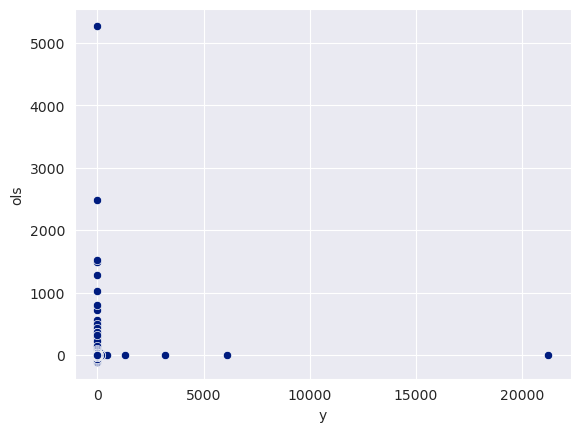

In [12]:
sns.scatterplot(x=df_master["y"], y=df_master["ols"])

In [7]:
test_data = {}
data = {}



for i, fold_data in enumerate(wf.folds()):
    size = fold_data[4]
    y_test = fold_data[5]

    test_data[i] = [size, y_test]
    data[i] = fold_data
    print(i)
    #if i == fold_num:
    #    break

0


In [50]:
names = ["exp_042_lstm_100_sgd", "exp_036_lstm_100_muon_lr"]
names = sorted(names)
print(names)
cfgs = [cfg_lstm, cfg_lstm]
trials = ["trial_search_best", "trial_search_best"]
fold_num = 0

base_paths = [f"{VOL_EXPERIMENTS_DIR}/{name}/{trial}/" for name, trial in zip(names, trials)]
ckpt_paths = [f"{base}fold_{fold_num:03d}/model_best.pt" for base in base_paths]

checkpoints = [torch.load(ckpt_path, map_location=DEVICE) for ckpt_path in ckpt_paths]

# Assigning specific checkpoints to variables for clarity
checkpoint_mlp = checkpoints


['exp_036_lstm_100_muon_lr', 'exp_042_lstm_100_sgd']


In [96]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import torch
import numpy as np
from models import create_model

def _prepare_X_for_ols(X: np.ndarray) -> np.ndarray:
    X = np.asarray(X)
    if X.ndim == 1:
        return X.reshape(-1, 1)
    if X.ndim == 2:
        return X
    if X.ndim == 3:
        N, T, D = X.shape
        return X.reshape(N, T * D)
    raise ValueError(f"Unexpected X shape for OLS: {X.shape}")

# Replace the existing _infer_input_shape with this version
def _infer_input_shape(cfg, X_sample, state_dict):
    """
    Infer model input_shape from a sample.
    Accepts:
      (T,)          -> univariate row
      (T,D)         -> multivariate row
      (N,T)         -> whole univariate batch
      (N,T,D)       -> whole multivariate batch
    Returns shapes expected by create_model for each architecture.
    """
    name = cfg.model.name.lower()
    shape = X_sample.shape
    # Remove leading batch dimension if accidentally passed
    if X_sample.ndim == 2 and name == "lstm" and shape[0] != cfg.walkforward.lags and shape[1] == cfg.walkforward.lags:
        # Probably (N,T); leave as handled below
        pass

    if name == "lstm":
        # LSTM expects (T,D)
        if X_sample.ndim == 1:              # (T,)
            return (shape[0], 1)
        elif X_sample.ndim == 2:
            if shape[0] == cfg.walkforward.lags and shape[1] != 1:
                # row already (T,D)
                return (shape[0], shape[1])
            elif shape[1] == cfg.walkforward.lags:
                # batch (N,T) -> treat as univariate features
                return (shape[1], 1)
            else:
                # row (T,1) or (T,D)
                return (shape[0], shape[1])
        elif X_sample.ndim == 3:            # (N,T,D)
            return (shape[1], shape[2])
        else:
            raise ValueError(f"Unexpected LSTM sample shape: {shape}")

    elif name == "simplecnn":
        # CNN expects (C,L) with C=1
        if X_sample.ndim == 1:              # (T,)
            return (1, shape[0])
        elif X_sample.ndim == 2:
            if shape[1] == cfg.walkforward.lags and shape[0] != 1:
                # (N,T) batch -> length = T
                return (1, shape[1])
            elif shape[0] == 1:             # (1,T)
                return (1, shape[1])
            else:                           # (T,D) flattened later
                return (1, shape[0]*shape[1])
        elif X_sample.ndim == 3:            # (N,T,D)
            return (1, shape[1])            # treat D collapsed upstream
        else:
            raise ValueError(f"Unexpected CNN sample shape: {shape}")

    elif name == "mlp":
        # MLP expects flattened window (T,) (or T*D)
        if X_sample.ndim == 1:              # (T,)
            return (shape[0],)
        elif X_sample.ndim == 2:
            if shape[1] == cfg.walkforward.lags and shape[0] != cfg.walkforward.lags:
                # (N,T) batch
                return (shape[1],)
            else:                           # (T,D)
                return (shape[0]*shape[1],)
        elif X_sample.ndim == 3:            # (N,T,D)
            return (shape[1]*shape[2],)
        else:
            raise ValueError(f"Unexpected MLP sample shape: {shape}")

    else:
        raise ValueError(f"Unknown model {cfg.model.name}")

@torch.inference_mode()
def _prepare_batch(cfg, x_row):
    name = cfg.model.name.lower()
    # x_row is a single sample slice from X_test
    if name == "mlp":
        if x_row.ndim == 1:
            xb = torch.as_tensor(x_row, dtype=torch.float32).unsqueeze(0)
        elif x_row.ndim == 2:
            xb = torch.as_tensor(x_row.reshape(-1), dtype=torch.float32).unsqueeze(0)
        else:
            raise ValueError
    elif name == "simplecnn":
        # expect (N, C, L); x_row maybe (T,) or (T,D)
        if x_row.ndim == 1:
            xb = torch.as_tensor(x_row, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        elif x_row.ndim == 2:
            # collapse feature dim
            x_flat = x_row.reshape(-1)
            xb = torch.as_tensor(x_flat, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        else:
            raise ValueError
    elif name == "lstm":
        # expect (N, T, D)
        if x_row.ndim == 1:
            xb = torch.as_tensor(x_row, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
        elif x_row.ndim == 2:
            xb = torch.as_tensor(x_row, dtype=torch.float32).unsqueeze(0)
        else:
            raise ValueError
    else:
        raise ValueError
    return xb

def build_model_from_checkpoint(cfg, checkpoint, X_example):
    state_dict = {k.replace("_orig_mod.", ""): v for k, v in checkpoint["model_state"].items()}
    input_shape = _infer_input_shape(cfg, X_example, state_dict)
    output_shape = cfg.walkforward.lookback + 1 if cfg.walkforward.lookback is not None else 1
    model = create_model(cfg.model, input_shape, output_shape)
    model.load_state_dict(state_dict, strict=True)
    model.to(DEVICE).eval()
    return model

@torch.inference_mode()
def infer_sequential(model, cfg, X_test, y_test, limit=None, autoregressive=False, device="cuda"):
    """
    Sequential single-row inference over chronologically sorted X_test.
    For autoregressive=True, we start from X_test[0] and then roll forward
    using our own predictions.
    Returns (y_true, preds) with shape (N, output_dim).
    """
    preds = []
    limit = len(X_test) if limit is None else limit

    if autoregressive:
        # Keep a *list* of windows; each window has same shape as X_test[0]
        X_ar = [np.array(X_test[0], copy=True)]
    else:
        X_ar = None

    for i in range(limit):
        if autoregressive:
            # Always feed the *last* window in the autoregressive buffer
            x_in = X_ar[-1]
        else:
            x_in = X_test[i]

        # Debug: check shapes
        # print("x_in shape:", np.asarray(x_in).shape)

        xb = _prepare_batch(cfg, x_in).to(device)  # should match training input shape
        pb = model(xb).detach().cpu().numpy().reshape(-1)  # (output_dim,)
        preds.append(pb)

        if autoregressive:
            # assume scalar output; if multi-dim adjust accordingly
            next_val = pb[0]

            # x_in is a window of length L; we drop the first element and append the prediction
            x_in = np.asarray(x_in)
            next_window = np.concatenate([x_in[1:], [next_val]])

            # store new window in buffer
            X_ar.append(next_window)

    preds = np.vstack(preds)  # (N, output_dim)
    y_true = np.asarray(y_test[:limit])
    if y_true.ndim == 1:
        y_true = y_true.reshape(-1, 1)

    return y_true, preds

def plot_forecast_overlay(x_input, y_true, y_pred, title="Forecast overlay", horizon_dim: int = 0):
    """
    Plot with an initial burn-in window (the model input) followed by sequential forecasts.
    Assumes:
      x_input: shape (T,) or (T,D)  -> last observed history used for first prediction
      y_true : shape (N, H) or (N,1)
      y_pred : shape (N, H) or (N,1)
    horizon_dim selects which target dimension to display (default 0).
    """
    # Extract burn-in (history) series
    x_input = np.asarray(x_input)
    if x_input.ndim == 2:
        history = x_input[:, horizon_dim] if x_input.shape[1] > horizon_dim else x_input[:, 0]
    else:
        history = x_input.ravel()

    # Extract forecast true/pred series for chosen horizon dimension
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    if y_true.ndim == 2:
        true_future = y_true[:, horizon_dim] if y_true.shape[1] > horizon_dim else y_true[:, 0]
    else:
        true_future = y_true.ravel()
    if y_pred.ndim == 2:
        pred_future = y_pred[:, horizon_dim] if y_pred.shape[1] > horizon_dim else y_pred[:, 0]
    else:
        pred_future = y_pred.ravel()

    T = len(history)
    F = len(true_future)

    # Build unified time index: negative = burn-in, non-negative = forecast
    idx_history = np.arange(-T, 0)
    idx_future  = np.arange(0, F)

    plt.figure(figsize=(12,4))
    plt.plot(idx_history, history, label="History", color="#555555", lw=2)
    plt.plot(idx_future, true_future, label="True Future", color="#1f77b4", lw=2)
    plt.plot(idx_future, pred_future, label="Predicted Future", color="#d62728", lw=2)

    # Vertical separator at forecast start
    plt.axvline(x=-0.5, color="k", linestyle="--", linewidth=1)
    plt.axhline(y=pred_future[0], color="r", linestyle="--", linewidth=1)

    # Metrics
    if len(true_future) == len(pred_future):
        mse = mean_squared_error(true_future, pred_future)
        plt.text(0.9, 0.97, f"MSE={mse:.4g}",
                 transform=plt.gca().transAxes, va="top", ha="left", fontsize=10,
                 bbox=dict(boxstyle="round", fc="white", alpha=0.6, ec="#cccccc"))

    plt.title(f"{title})")
    plt.xlabel("Time (negative = burn-in history, >=0 = forecast steps)")
    plt.ylabel("Value")
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    
# ---- Usage example ----
# Assuming data[fold_num] loaded earlier:
Xtr, ytr, Xv, yv, Xte, yte, Xtr_val, ytr_val, Xte_merged, yte_merged = data[fold_num]
X_test_use = Xte  # or Xte_merged if merge mode
y_test_use = yte
print(X_test_use.shape)

X_test_ols = prepare_sklearn_input(X_test_use)
y_pred_ols = ols_full.predict(X_test_ols)

# Forecast model
##--------- First ---------##
model_first = build_model_from_checkpoint(cfgs[0], checkpoints[0], X_test_use[0])
#y_true_seq, y_pred_seq_ar_cnn = infer_sequential(model_cnn, cfg_cnn, X_test_use, y_test_use, limit=200, autoregressive=True)
y_true_seq, y_pred_seq_first = infer_sequential(model_first, cfgs[0], X_test_use, y_test_use, limit=200)
#mse_model_cnn = mean_squared_error(y_true_seq[:, 0], y_pred_seq_ar_cnn[:, 0])
#print(f"Test Model MSE: {mse_model_cnn:.6f}")


##--------- Second ---------##
model_second = build_model_from_checkpoint(cfgs[1], checkpoints[1], X_test_use[0])
#y_true_seq, y_pred_seq_ar_lstm = infer_sequential(model_lstm, cfg_lstm, X_test_use, y_test_use, limit=200, autoregressive=True)
y_true_seq, y_pred_seq_second = infer_sequential(model_second, cfgs[1], X_test_use, y_test_use, limit=200)
#mse_model_lstm = mean_squared_error(y_true_seq[:, 0], y_pred_seq_ar_lstm[:, 0])
#print(f"Test Model LSTM MSE: {mse_model_lstm:.6f}")

##--------- third ---------##
#model_mlp = build_model_from_checkpoint(cfgs[2], checkpoints[2], X_test_use[0])
#y_true_seq, y_pred_seq_ar_muon = infer_sequential(model_mlp, cfg_lstm, X_test_use, y_test_use, limit=200, autoregressive=True)
#y_true_seq, y_pred_seq_mlp = infer_sequential(model_mlp, cfgs[2], X_test_use, y_test_use, limit=200)
#mse_model_mlp = mean_squared_error(y_true_seq[:, 0], y_pred_seq_ar_lstm[:, 0])
#print(f"Test Model muon MSE: {mse_model_mlp:.6f}")

#diff = y_pred_seq_sgd - y_pred_seq_mlp
#diff_norm = np.linalg.norm(diff)
#print(diff_norm)




(1104, 100)


In [11]:
#plt.figure(figsize=(12,8))
#sns.heatmap(pd.DataFrame(Xtr_val).corr())

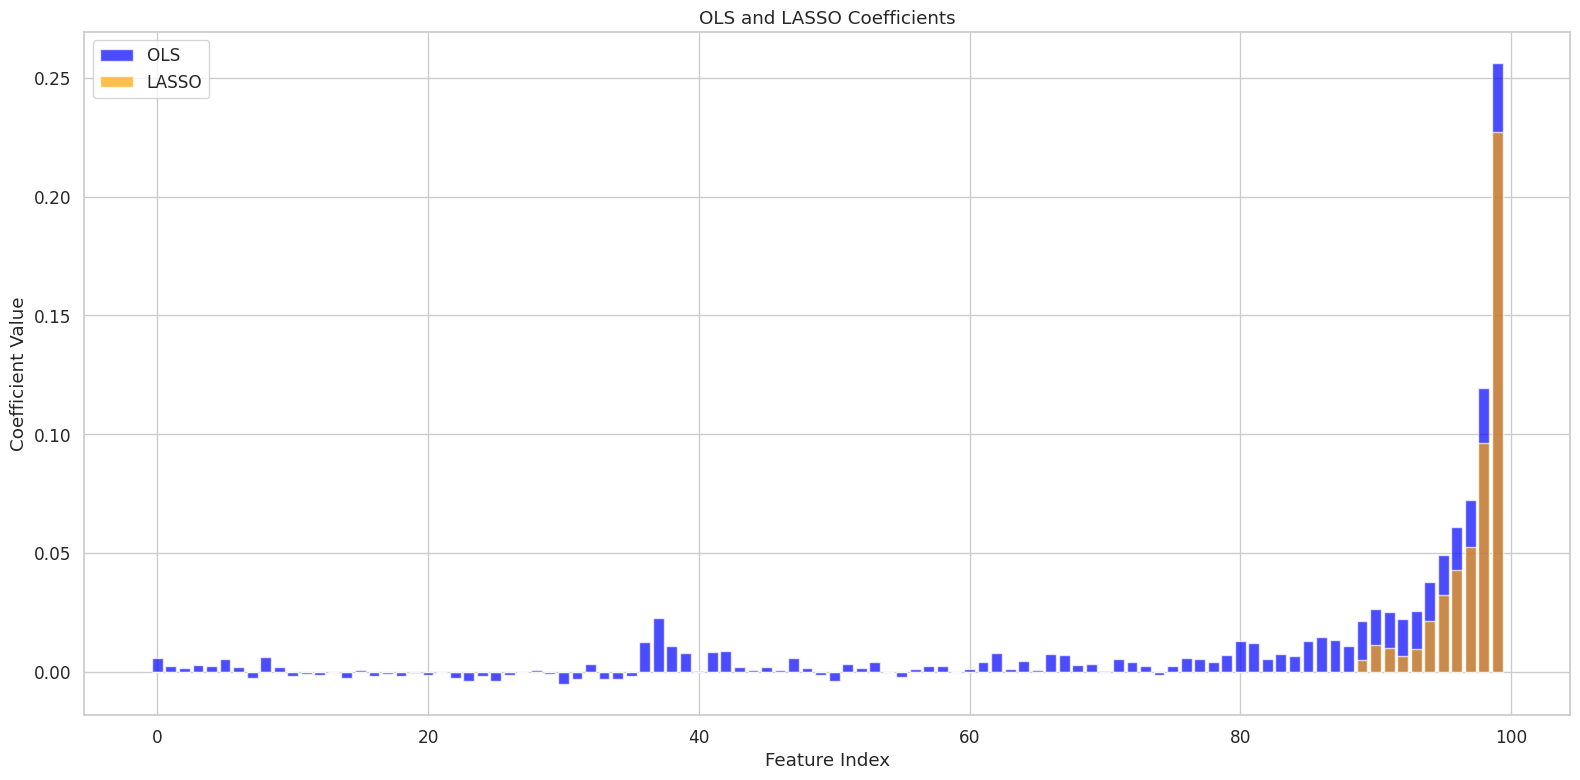

In [101]:
plt.figure(figsize=(16, 8))
plt.title("OLS and LASSO Coefficients")
plt.bar(range(len(ols_full.coef_)), ols_full.coef_, color='blue', alpha=0.7, label="OLS")
plt.bar(range(len(lasso_full.coef_)), lasso_full.coef_, color='orange', alpha=0.7, label="LASSO")
plt.legend()
plt.xlabel("Feature Index")
plt.ylabel("Coefficient Value")
plt.grid(True)
plt.tight_layout()
plt.show()



<Figure size 1000x600 with 0 Axes>

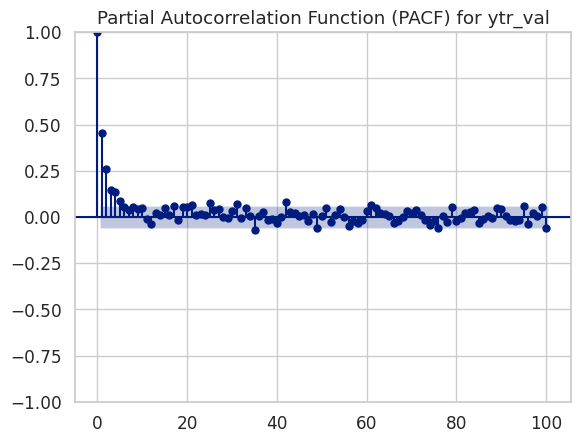

In [59]:
from statsmodels.graphics.tsaplots import plot_pacf

import matplotlib.pyplot as plt

# Plot PACF for ytr_val
plt.figure(figsize=(10, 6))
plot_pacf(y_test_use, lags=100, method='ywm', alpha=0.05)
plt.title("Partial Autocorrelation Function (PACF) for ytr_val")
plt.show()

In [60]:
@torch.inference_mode()
def probe_num(model, cfg, size, num=1, limit=None, autoregressive=False, device="cuda"):
    """
    Sequential single-row inference over chronologically sorted X_test.
    For autoregressive=True, we start from X_test[0] and then roll forward
    using our own predictions.
    Returns (y_true, preds) with shape (N, output_dim).
    """
    preds = []
    limit = size if limit is None else limit
    
    X_ar = None

    for i in range(limit):
        x_in = [0] * i + [num] + [0] *(limit-i-1)
        x_in = np.array(x_in)

        # Debug: check shapes
        # print("x_in shape:", np.asarray(x_in).shape)

        xb = _prepare_batch(cfg, x_in).to(device)  # should match training input shape
        pb = model(xb).detach().cpu().numpy().reshape(-1)  # (output_dim,)
        preds.append(pb)

        if autoregressive:
            # assume scalar output; if multi-dim adjust accordingly
            next_val = pb[0]

            # x_in is a window of length L; we drop the first element and append the prediction
            x_in = np.asarray(x_in)
            next_window = np.concatenate([x_in[1:], [next_val]])

            # store new window in buffer
            X_ar.append(next_window)

    preds = np.vstack(preds)  # (N, output_dim)

    return preds.reshape(-1)

@torch.inference_mode()
def test_random_uniform(model, cfg, size, low=-1.0, high=1.0, n_samples=100, seed=None, device="cuda"):
    """
    Feed the model random uniform noise vectors of dimension `size`.
    Returns predictions of shape (n_samples,).
    """
    if seed is not None:
        np.random.seed(seed)

    preds = []

    for _ in range(n_samples):
        x_in = np.random.uniform(low, high, size=size).astype(float)
        xb = _prepare_batch(cfg, x_in).to(device)
        pb = model(xb).detach().cpu().numpy().reshape(-1)
        preds.append(pb)

    preds = np.vstack(preds)  # (n_samples, output_dim)
    return preds.squeeze()



@torch.inference_mode()
def test_gaussian_noise(model, cfg, size, mean=0.0, std=1.0, n_samples=100, seed=None, device="cuda"):
    """
    Feed the model random Gaussian noise vectors N(mean, std^2)
    of dimension `size`.
    Returns predictions of shape (n_samples,).
    """
    if seed is not None:
        np.random.seed(seed)

    preds = []

    for _ in range(n_samples):
        x_in = np.random.normal(loc=mean, scale=std, size=size).astype(float)
        xb = _prepare_batch(cfg, x_in).to(device)
        pb = model(xb).detach().cpu().numpy().reshape(-1)
        preds.append(pb)

    preds = np.vstack(preds)
    return preds.squeeze()




In [61]:
from models import create_model
import json
from pathlib import Path

# Normalize MSE by target variance on each split
USE_NMSE = True
MERGE_TRAIN_VAL = False



# =========================
# Utilities
# =========================
def load_cfg(base) -> AppConfig:
    cfg_json = json.loads((base / "config_snapshot.json").read_text())
    return AppConfig.from_dict(cfg_json["cfg"])

def _infer_lstm_input_size_from_ckpt(state_dict: dict) -> int | None:
    # look for first LSTM weight_ih
    for k, v in state_dict.items():
        if k.endswith("lstm_layers.0.weight_ih_l0") or ("lstm_layers.0.weight_ih_l0" in k):
            # shape is [4*H, input_size]
            return int(v.shape[1])
    # legacy single-module naming (if any)
    for k, v in state_dict.items():
        if k.endswith("lstm.weight_ih_l0") or ("lstm.weight_ih_l0" in k):
            return int(v.shape[1])
    return None

def _make_input_shape_for_eval(cfg, X_sample: torch.Tensor | np.ndarray, state_dict: dict):
    name = cfg.model.name.lower()
    # infer T and (optional) D from the data
    if isinstance(X_sample, np.ndarray):
        shape = X_sample.shape
    else:
        shape = tuple(X_sample.shape)
    # shape is typically (N, T) or (N, T, D)
    if len(shape) == 2:
        _, T = shape
        D_data = 1
    elif len(shape) == 3:
        _, T, D_data = shape
    else:
        raise ValueError(f"Unexpected batch shape for X: {shape}")

    if name == "lstm":
        D_ckpt = _infer_lstm_input_size_from_ckpt(state_dict)
        D = D_ckpt if D_ckpt is not None else D_data  # prefer ckpt
        return (T, D)
    elif name == "simplecnn":
        # your CNN expects (C, L) with C=1
        return (1, T)
    elif name == "mlp":
        # your MLP code expects (T,) as before (flattened window)
        return (T,)
    else:
        raise ValueError(f"Unknown model name: {cfg.model.name}")

@torch.inference_mode()
def _predict_batched(model, X, device="cuda", bs=8192):
    preds = []
    for i in range(0, len(X), bs):
        xb = torch.as_tensor(X[i:i+bs], dtype=torch.float32, device=device)
        pb = model(xb).detach().cpu()
        preds.append(pb)
    return torch.cat(preds, dim=0).numpy()

def load_and_predict_nn(base_path, fold_idx, X_test, device="cuda"):
    """Load NN model for given fold and make predictions on test set."""
    try:
        base_path = Path(base_path)
        cfg = load_cfg(base_path)
        # Load checkpoint
        ckpt_path = base_path / f"fold_{fold_idx:03d}" / "model_best.pt"
        if not ckpt_path.exists():
            return None
        
        checkpoint = torch.load(ckpt_path, map_location=device)
        state_dict = {k.replace("_orig_mod.", ""): v for k, v in checkpoint["model_state"].items()}
        
        # Infer shapes
        input_shape = _make_input_shape_for_eval(cfg, X_test, state_dict)
        output_shape = cfg.walkforward.lookback + 1 if cfg.walkforward.lookback is not None else 1
        
        # Create and load model
        model = create_model(cfg.model, input_shape, output_shape)
        model.load_state_dict(state_dict, strict=True)
        model.to(device).eval()
        
        # Make predictions
        yhat = _predict_batched(model, X_test, device=device, bs=8192)
        
        # Cleanup
        del model, checkpoint
        torch.cuda.empty_cache()
        
        return yhat
        
    except Exception as e:
        print(f"Error loading/predicting fold {fold_idx}: {e}")
        return None
